In [1]:
from scripts import setup_environment

setup_environment()

In [2]:
from scripts.dataset import BrainteaserDataset

dataset = BrainteaserDataset("data")

In [3]:
import string

from scripts.dataset import RiddleQuestion
from scripts.prompt_helpers import create_prompt_template


def args_generator(riddle_question: RiddleQuestion):
    template_args = {
        "question": riddle_question.question,
        "choices": "\n".join(
            [
                f"({string.ascii_uppercase[j]}) {choice}"
                for j, choice in enumerate(riddle_question.choice_list)
            ]
        ),
    }

    return template_args


chat_prompt_template = create_prompt_template("default")

In [4]:
from scripts.lmm import OllamaModelBuilder
from scripts.executor import Executor

base_url = "http://142.214.185.26:40001"
model_builder = OllamaModelBuilder(base_url)

executor = Executor(
    models=[
        # Llama3.1
        model_builder.build_model("llama3.1:8b-instruct-q8_0"),  # => 9 GB
        # Llama3.2
        model_builder.build_model("llama3.2:1b-instruct-fp16"),  # => 2.5 GB
        model_builder.build_model("llama3.2:3b-instruct-fp16"),  # => 6.4 GB
        # Phi3.5
        model_builder.build_model("phi3.5:3.8b-mini-instruct-fp16"),  # => 7.6 GB
        # Phi4
        model_builder.build_model("phi4:14b-q8_0"),  # => 16 GB
        # Qwen2.5
        model_builder.build_model("qwen2.5:0.5b-instruct-fp16"),  # => 1 GB
        model_builder.build_model("qwen2.5:1.5b-instruct-fp16"),  # => 3.1 GB
        model_builder.build_model("qwen2.5:3b-instruct-fp16"),  # => 6.2 GB
        model_builder.build_model("qwen2.5:7b-instruct-q8_0"),  # => 8.1 GB
        model_builder.build_model("qwen2.5:14b-instruct-q8_0"),  # => 16 GB
        model_builder.build_model("qwen2.5:32b-instruct-q4_K_M"),  # => 20 GB
        # Gemma2
        model_builder.build_model("gemma2:2b-instruct-fp16"),  # => 5.2 GB
        model_builder.build_model("gemma2:9b-instruct-q8_0"),  # => 9.8 GB
        model_builder.build_model("gemma2:27b-instruct-q4_K_M"),  # => 22 GB
        # Mistral Nemo
        model_builder.build_model("mistral-nemo:12b-instruct-2407-q8_0"),  # => 13 GB
    ]
)

2025-03-15 18:02:04,578 - INFO - Initialized executor with 15 models.


In [5]:
import numpy as np

from scripts.executor import Dataset

# Set fixed seed for reproducibility
np.random.seed(42)


def create_test_dataset(data: list[RiddleQuestion], name: str, percentage: float = 0.1):
    """Create a test dataset by randomly sampling a percentage of the original data."""
    indices = np.random.choice(
        len(data), size=int(len(data) * percentage), replace=False
    )
    return Dataset(name=name, riddles=[data[i] for i in indices])


# Create test datasets
sp_data = create_test_dataset(dataset.sp, "sp")
wp_data = create_test_dataset(dataset.wp, "wp")

# Prepare executor data
executor_data = [sp_data, wp_data]

In [6]:
import dill as pickle

# Get the best prompt type for each model
with open("results/best_system_prompts_by_model.pkl", "rb") as f:
    best_prompt_types = pickle.load(f)


def create_prompt_template_by_model(
    model_name: str,
    dataset_name: str,
):
    best_system_template_name = best_prompt_types[model_name][dataset_name][
        "prompt_type"
    ]
    return create_prompt_template(best_system_template_name)


def get_prompt_template(model_name: str, dataset: Dataset):
    # Split name after the b paramer, e.g., llama3.1:8b-instruct-fp16 => llama3.1:8b
    model_name = model_name[0 : model_name.index("b-") + 1]
    chat_prompt_template = create_prompt_template_by_model(model_name, dataset.name)
    return chat_prompt_template

In [7]:
for run_index in range(5):
    results = await executor.aexecute(
        executor_data,
        get_prompt_template,
        args_generator,
        dump_to_pickle=True,
        create_checkpoints=True,
        resume_from_checkpoint=True,
        run_name="model_speed",
        file_name_suffix=f"run_{run_index}",
    )

2025-03-15 18:02:04,604 - INFO - Starting execution 'model-speed with suffix 'run_0'': 2 dataset(s) x 15 model(s) = 1665 riddle evaluations


model-speed(run-0):   0%|          | 0/1665 [00:00<?, ?it/s]

TypeError: cannot unpack non-iterable WrappedResults object

## Eval results


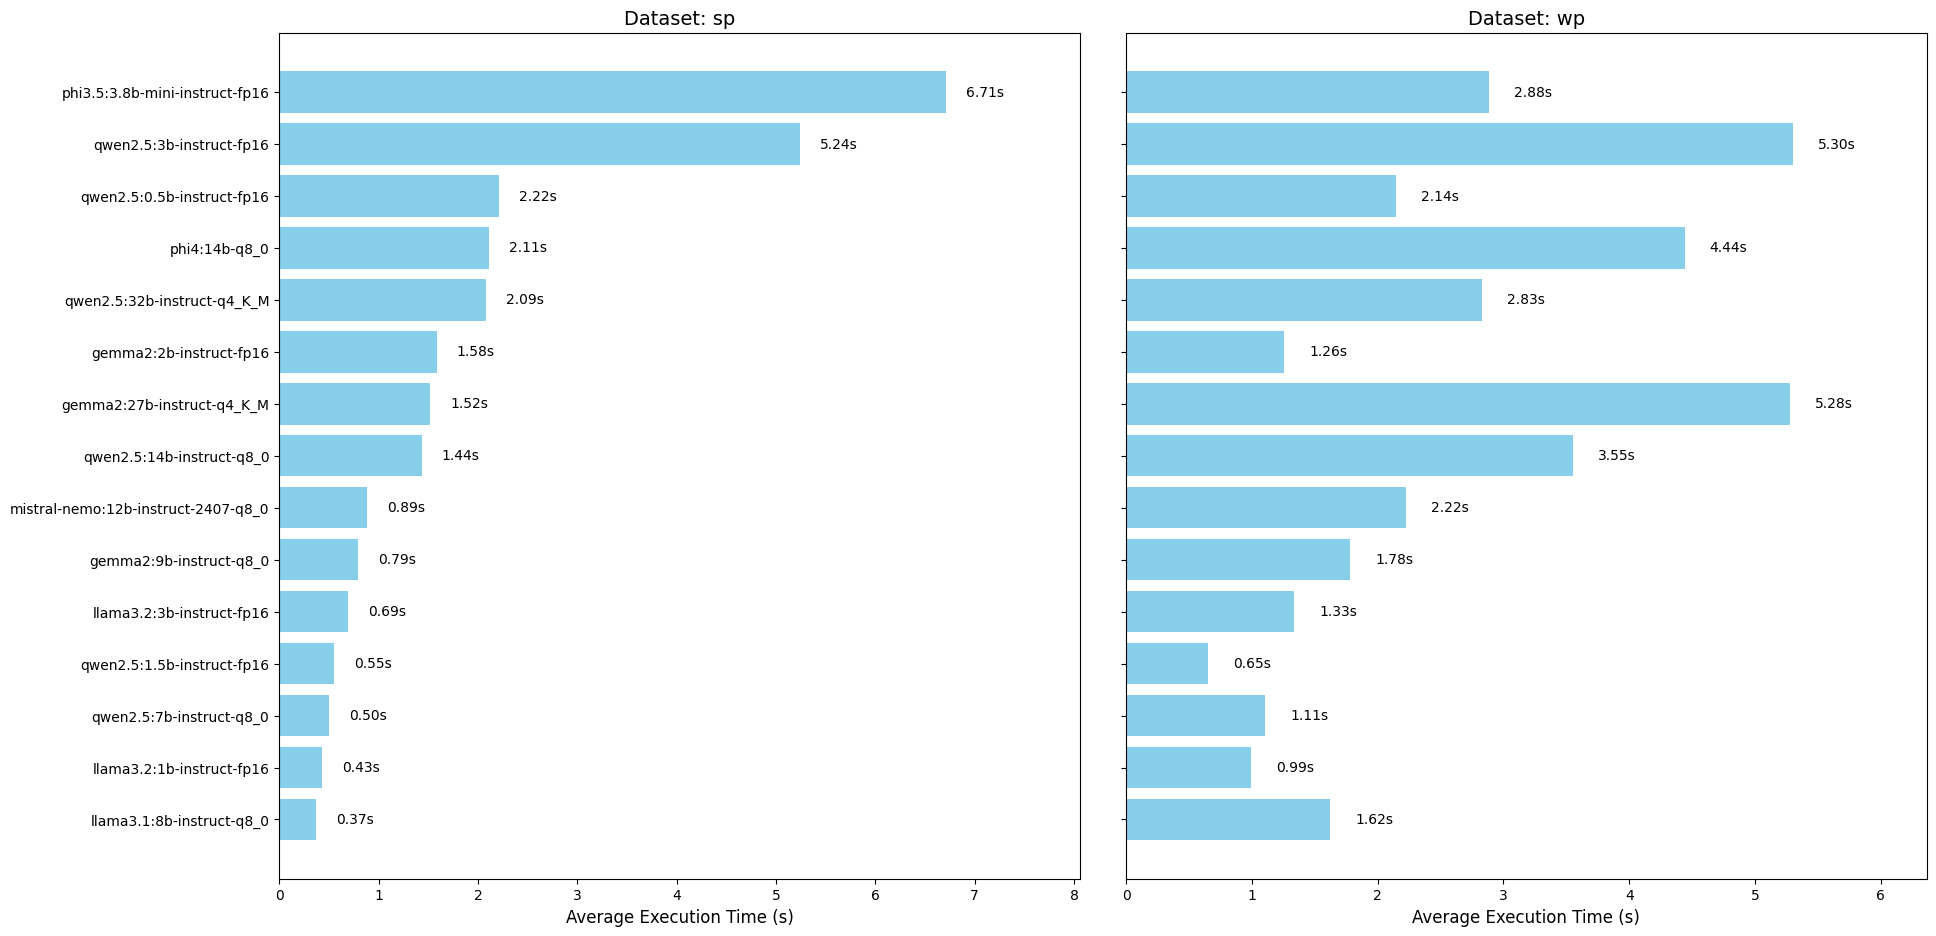

defaultdict(dict,
            {'sp': {'llama3.1:8b-instruct-q8_0': 0.37014486328248053,
              'llama3.2:1b-instruct-fp16': 0.43110398323305194,
              'llama3.2:3b-instruct-fp16': 0.6926287335734214,
              'phi3.5:3.8b-mini-instruct-fp16': 6.71397731765624,
              'phi4:14b-q8_0': 2.111756036358495,
              'qwen2.5:0.5b-instruct-fp16': 2.215768210349544,
              'qwen2.5:1.5b-instruct-fp16': 0.5490797142828664,
              'qwen2.5:3b-instruct-fp16': 5.2400543228272465,
              'qwen2.5:7b-instruct-q8_0': 0.5010901228074105,
              'qwen2.5:14b-instruct-q8_0': 1.4363208816897484,
              'qwen2.5:32b-instruct-q4_K_M': 2.086032332912568,
              'gemma2:2b-instruct-fp16': 1.5839722156524658,
              'gemma2:9b-instruct-q8_0': 0.7940561002300631,
              'gemma2:27b-instruct-q4_K_M': 1.5197233346200758,
              'mistral-nemo:12b-instruct-2407-q8_0': 0.8873263559033794},
             'wp': {'llama3.1:8

In [ ]:
import glob
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scripts.executor import WrappedResults

# Find all result files from previous runs
result_files = glob.glob("results/model-speed/model-speed_run-*_results.pkl")

# Process the timing data from all result files
all_timing_data = defaultdict(lambda: defaultdict(list))

data = defaultdict(dict)
for result_file in result_files:
    with open(result_file, "rb") as f:
        wrapped_results: WrappedResults = pickle.load(f)

    for dataset, results in wrapped_results.results.items():
        for model_name, model_results in results.items():
            times = [x.get_execution_time() for x in model_results]
            avg = np.average(times)
            data[dataset][model_name] = avg

# Convert the nested dictionary to a DataFrame for easier plotting
df = pd.DataFrame()
for dataset, model_dict in data.items():
    temp_df = pd.DataFrame(list(model_dict.items()), columns=["model", "time"])
    temp_df["dataset"] = dataset
    df = pd.concat([df, temp_df], ignore_index=True)

# Create a figure with subplots for each dataset
fig, axes = plt.subplots(1, len(data), figsize=(20, 10), sharey=True)
if len(data) == 1:
    axes = [axes]  # Handle the case of a single dataset

for i, dataset in enumerate(data.keys()):
    dataset_df = df[df["dataset"] == dataset]
    dataset_df = dataset_df.sort_values("time")

    ax = axes[i]
    bars = ax.barh(dataset_df["model"], dataset_df["time"], color="skyblue")
    ax.set_title(f"Dataset: {dataset}", fontsize=14)
    ax.set_xlabel("Average Execution Time (s)", fontsize=12)
    ax.tick_params(axis="y", labelsize=10)

    # Add time values at the end of each bar
    for bar, time in zip(bars, dataset_df["time"], strict=False):
        ax.text(
            bar.get_width() + 0.2,
            bar.get_y() + bar.get_height() / 2,
            f"{time:.2f}s",
            va="center",
        )

    # Ensure there's enough space for the labels
    ax.set_xlim(0, max(dataset_df["time"]) * 1.2)

plt.tight_layout(pad=3.0)
plt.show()

# Also display the original data for reference
display(data)